# 라이브러리 로드

In [ ]:
# !pip install torchviz

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

# 데이터 로드

In [ ]:
filepath = 'https://github.com/mchoimis/tsdl/raw/main/sales/'

sales = pd.read_csv(filepath + 'train.csv')
item_cat = pd.read_csv(filepath + 'item-category.csv')
item = pd.read_csv(filepath + 'items.csv')
shops = pd.read_csv(filepath + 'shops.csv')
test = pd.read_csv(filepath + 'test.csv')

In [ ]:
sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [ ]:
# 모델 훈련 데이터 생성
# 2013년 1월 ~ 2015년 10월까지의 데이터로 이후 5개월치 데이터 예측
ts = sales.groupby(['date_block_num'])['item_cnt_day'].sum()
ts.index = pd.date_range(start='2013-01-01', end='2015-10-01', freq='MS')
ts = ts.reset_index()
ts.columns = ['date', 'item_cnt']

ts.head()

,date,item_cnt
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


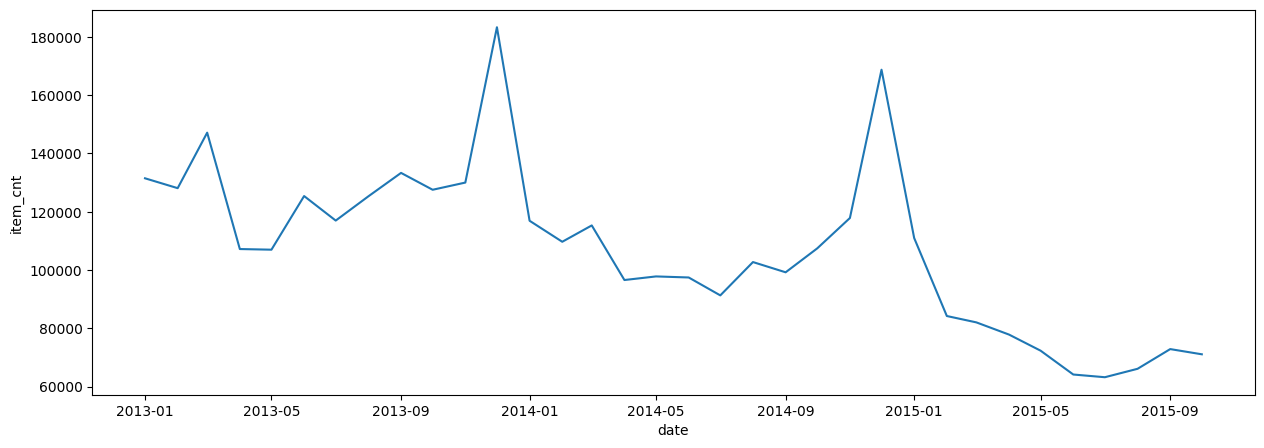

In [ ]:
# monthly sales cnt plot
plt.figure(figsize=(15, 5))

sns.lineplot(
    data=ts,
    x='date',
    y='item_cnt'
)

plt.show()

# 데이터 전처리

In [ ]:
# 데이터 분할
# 데이터 역순 정렬 -> 2013년 1월 ~ 11월 데이터는 test set
train_df, test_df = train_test_split(ts, test_size=0.3, shuffle=False)

In [ ]:
# 정규화 수행
def normalize(train_set, test_set, scaler_opt: str='minmax'):

    train_set = train_set.copy()
    test_set = test_set.copy()

    if scaler_opt == 'standard': scaler = StandardScaler()
    if scaler_opt == 'robust': scaler = RobustScaler()
    if scaler_opt == 'minmax': scaler = MinMaxScaler()

    # train set 데이터에 맞게 scaler fit
    scaler.fit(train_set.iloc[:, [-1]])

    train_set.iloc[:, -1] = scaler.transform(train_set.iloc[:, [-1]])
    test_set.iloc[:, -1] = scaler.transform(test_set.iloc[:, [-1]])

    return scaler, train_set, test_set

scaler, normalized_train_df, normalized_test_df = normalize(train_df, test_df)

In [ ]:
# 데이터셋 생성 함수
def build_dataset(time_series, seq_length, target_length):

    dataX = []; dataY = []
    for i in range(len(time_series)-seq_length):

        _x = time_series[i : i+seq_length, [-1]] # 이전 seq_length 개월
        _y = time_series[i+seq_length : i+seq_length+target_length, [-1]] # 이후 target_length 개월

        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX, dtype=np.float64), np.array(dataY, dtype=np.float64)

seq_length = 5 # 훈련시킬 데이터 길이
target_length = 1 # 예측할 데이터 길이

trainX, trainY = build_dataset(np.array(normalized_train_df), seq_length, target_length)
testX, testY = build_dataset(np.array(normalized_test_df), seq_length, target_length)

In [ ]:
# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)

batch = 100

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(
                        dataset,
                        batch_size=batch,
                        shuffle=True,
                        drop_last=True
                      )

# LSTM 모델링

In [ ]:
# 설정값
data_dim = 1
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
nb_epochs = 50

In [ ]:
class Net(nn.Module):

    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers, dropout = 0.1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True)

    # 학습 초기화를 위한 함수
    def reset_hidden_state(self):
        self.hidden = (
                torch.zeros(self.layers, self.seq_len, self.hidden_dim),
                torch.zeros(self.layers, self.seq_len, self.hidden_dim)
        )

    # 예측을 위한 함수
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x

In [ ]:
model = Net(data_dim, hidden_dim, seq_length, output_dim, 1)
model

Net(
  (lstm): LSTM(1, 10, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
device = torch.device('cuda:0')

def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):

    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs

    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)

        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples
            x_train = x_train.to(device)
            y_train = y_train.to(device)

            # seq별 hidden state reset
            model.reset_hidden_state()

            # H(x) 계산
            outputs = model(x_train)

            # cost 계산
            loss = criterion(outputs, y_train)

            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            avg_cost += loss/total_batch

        train_hist[epoch] = avg_cost

        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))

        # # patience번째 마다 early stopping 여부 확인
        # if (epoch % patience == 0) & (epoch != 0):

        #     # loss가 커졌다면 early stop
        #     if train_hist[epoch-patience] < train_hist[epoch]:
        #         print('\n Early Stopping')

        #         break

    return model.eval(), train_hist

In [ ]:
# 모델 학습
net = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)
model, train_hist = train_model(net, dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 10, patience = 10)

Epoch: 0000 train loss : 0.0000
Epoch: 0010 train loss : 0.0000
Epoch: 0020 train loss : 0.0000
Epoch: 0030 train loss : 0.0000
Epoch: 0040 train loss : 0.0000


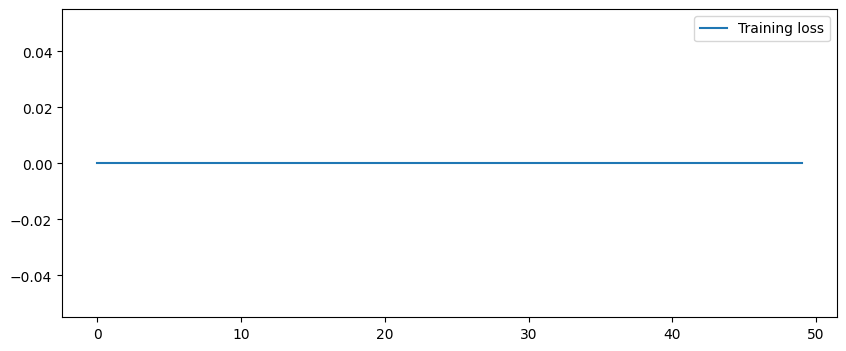

In [ ]:
# epoch별 손실값
fig = plt.figure(figsize=(10, 4))

plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

In [ ]:
# 예측 테스트
with torch.no_grad():
    pred = []
    for pr in range(len(testX_tensor)):

        testX_tensor = testX_tensor.to(device)

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(testX_tensor[pr], 0)).to(device)
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # INVERSE
    pred_inverse = scaler.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse = scaler.inverse_transform(testY_tensor.reshape(-1, 1))

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(pred_inverse, testY_inverse))

MAE SCORE :  5153.769031316045


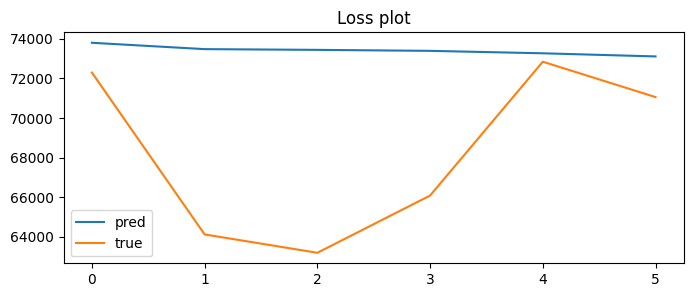

In [ ]:
fig = plt.figure(figsize=(8, 3))

plt.plot(np.arange(len(pred_inverse)), pred_inverse, label = 'pred')
plt.plot(np.arange(len(testY_inverse)), testY_inverse, label = 'true')

plt.legend()
plt.title("Loss plot")
plt.show()